In [1]:
import random

import numpy as np
import torch
from unityagents import UnityEnvironment

RANDOM_SEED = 0
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

env = UnityEnvironment(seed=RANDOM_SEED, file_name="Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [3]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)


class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, fc1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, fcs1_units=512, fc2_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(RANDOM_SEED)
        self.fcs1 = nn.Linear((state_size + action_size) * NUM_AGENTS, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        # Concatenates states and actions as the input of the first layer
        # DDPG does this before the second layer
        xs = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(xs))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [4]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, mu=0.0, theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(RANDOM_SEED)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.array([np.random.normal(loc=0, scale=1) for _ in range(len(x))])
        self.state = x + dx
        return self.state


class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(RANDOM_SEED)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [5]:
import copy
import os
import random
from collections import namedtuple, deque

import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class DDPGAgent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, agent_id):
        """Initialize a DDPGAgent object.
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            agent_id (int): identifier for this agent
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(RANDOM_SEED)
        self.agent_id = agent_id

        self.actor_local = Actor(state_size, action_size).to(device)
        self.actor_target = Actor(state_size, action_size).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        self.critic_local = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Make sure that the target-local model pairs are initialized to the 
        # same weights
        self.hard_update(self.actor_local, self.actor_target)
        self.hard_update(self.critic_local, self.critic_target)
        
        self.noise = OUNoise(action_size)
        
        self.noise_amplification = NOISE_AMPLIFICATION
        self.noise_amplification_decay = NOISE_AMPLIFICATION_DECAY
        
        self._print_network()

    def act(self, state, add_noise=False):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        
        if add_noise:
            action += self.noise.sample()
            self._decay_noise_amplification()
        
        return np.clip(action, -1, 1)

    def reset(self):
        """Resets the OU Noise for this agent."""
        self.noise.reset()
        
    def learn(self, experiences, next_actions, actions_pred):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(next_state) -> action
            critic_target(next_state, next_action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            next_actions (list): next actions computed from each agent
            actions_pred (list): prediction for actions for current states from each agent
        """
        states, actions, rewards, next_states, dones = experiences
        agent_id_tensor = torch.tensor([self.agent_id - 1]).to(device)

        ### Update critic
        self.critic_optimizer.zero_grad()
        Q_targets_next = self.critic_target(next_states, next_actions)        
        Q_targets = rewards.index_select(1, agent_id_tensor) + (GAMMA * Q_targets_next * (1 - dones.index_select(1, agent_id_tensor)))
        Q_expected = self.critic_local(states, actions)
        # Minimize the loss
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        critic_loss.backward()
        self.critic_optimizer.step()

        ### Update actor
        self.actor_optimizer.zero_grad()
        # Minimize the loss
        actor_loss = -self.critic_local(states, actions_pred).mean()
        actor_loss.backward()
        self.actor_optimizer.step()

        ### Update target networks
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def hard_update(self, local_model, target_model):
        """Hard update model parameters.
        θ_target = θ_local
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(local_param.data)

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ * θ_local + (1 - τ) * θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
    
    def _print_network(self):
        """Helper to print network architecture for this agent's actors and critics."""
        print("Agent #{}".format(self.agent_id))
        print("Actor (Local):")
        print(self.actor_local)
        print("Actor (Target):")
        print(self.actor_target)
        print("Critic (Local):")
        print(self.critic_local)
        print("Critic (Target):")
        print(self.critic_target)
        if self.agent_id != NUM_AGENTS:
            print("_______________________________________________________________")
            
    def _decay_noise_amplification(self):
        """Helper for decaying exploration noise amplification."""
        self.noise_amplification *= self.noise_amplification_decay


class MADDPGAgent():
    """Wrapper class managing different agents in the environment."""

    def __init__(self, num_agents, state_size, action_size):
        """Initialize a MADDPGAgent wrapper.
        Params
        ======
            num_agents (int): the number of agents in the environment
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.num_agents = num_agents
        self.state_size = state_size
        self.action_size = action_size
        
        self.agents = [DDPGAgent(state_size, action_size, i+1) for i in range(num_agents)]
        
        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE)
        
        # Will help to decide when to update the model weights
        self.t_step = 0
        
        # Directory where to save the model
        self.model_dir = os.getcwd() + "/saved_models"
        os.makedirs(self.model_dir, exist_ok=True)
    
    def reset(self):
        """Resets OU Noise for each agent."""
        for agent in self.agents:
            agent.reset()
            
    def act(self, observations, add_noise=False):
        """Picks an action for each agent given their individual observations 
        and the current policy."""
        actions = []
        for agent, observation in zip(self.agents, observations):
            action = agent.act(observation, add_noise=add_noise)
            actions.append(action)
        return np.array(actions)
    
    def step(self, states, actions, rewards, next_states, dones):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        states = states.reshape(1, -1)
        actions = actions.reshape(1, -1)
        next_states = next_states.reshape(1, -1)
        
        self.memory.add(states, actions, rewards, next_states, dones)
        
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE and self.t_step == 0:
            for a_i, agent in enumerate(self.agents):
                experiences = self.memory.sample()
                self.learn(experiences, a_i)
            
    def learn(self, experiences, agent_number):
        """Helper to pick actions from each agent for the `experiences` tuple that 
        will be used to update the weights to agent with ID = `agent_number`.
        Each observation in the `experiences` tuple contains observations from each 
        agent, so before using the tuple of update the weights of an agent, we need 
        all agents to contribute in generating `next_actions` and `actions_pred`. 
        This happens because the critic will take as its input the combined 
        observations and actions from all agents."""
        next_actions = []
        actions_pred = []
        states, _, _, next_states, _ = experiences
        
        next_states = next_states.reshape(-1, self.num_agents, self.state_size)
        states = states.reshape(-1, self.num_agents, self.state_size)
        
        for a_i, agent in enumerate(self.agents):
            agent_id_tensor = self._get_agent_number(a_i)
            
            state = states.index_select(1, agent_id_tensor).squeeze(1)
            next_state = next_states.index_select(1, agent_id_tensor).squeeze(1)
            
            next_actions.append(agent.actor_target(next_state))
            actions_pred.append(agent.actor_local(state))
            
        next_actions = torch.cat(next_actions, dim=1).to(device)
        actions_pred = torch.cat(actions_pred, dim=1).to(device)
        
        agent = self.agents[agent_number]
        agent.learn(experiences, next_actions, actions_pred)
            
    def save_model(self):
        """Saves model weights to file."""
        for i in range(self.num_agents):
            torch.save(
                self.agents[i].actor_local.state_dict(), 
                os.path.join(self.model_dir, 'actor_params.pth')
            )
            torch.save(
                self.agents[i].actor_optimizer.state_dict(), 
                os.path.join(self.model_dir, 'actor_optim_params.pth')
            )
            torch.save(
                self.agents[i].critic_local.state_dict(), 
                os.path.join(self.model_dir, 'critic_params.pth')
            )
            torch.save(
                self.agents[i].critic_optimizer.state_dict(), 
                os.path.join(self.model_dir, 'critic_optim_params.pth')
            )
    
    def load_model(self):
        """Loads weights from saved model."""
        for i in range(self.num_agents):
            self.agents[i].actor_local.load_state_dict(
                torch.load(os.path.join(self.model_dir, 'actor_params_{}.pth'.format(i)))
            )
            self.agents[i].actor_optimizer.load_state_dict(
                torch.load(os.path.join(self.model_dir, 'actor_optim_params_{}.pth'.format(i)))
            )
            self.agents[i].critic_local.load_state_dict(
                torch.load(os.path.join(self.model_dir, 'critic_params_{}.pth'.format(i)))
            )
            self.agents[i].critic_optimizer.load_state_dict(
                torch.load(os.path.join(self.model_dir, 'critic_optim_params_{}.pth'.format(i)))
            )
    
    def _get_agent_number(self, i):
        """Helper to get an agent's number as a Torch tensor."""
        return torch.tensor([i]).to(device)

In [6]:
BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 512        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 5e-2              # for soft update of target parameters
LR_ACTOR = 5e-4         # learning rate of the actor 
LR_CRITIC = 5e-4        # learning rate of the critic
WEIGHT_DECAY = 0.0      # L2 weight decay
UPDATE_EVERY = 2
NUM_AGENTS = num_agents
STATE_SIZE = int(state_size)  # this environment has 3 time frames stacked together as its state
ACTION_SIZE = action_size
NOISE_AMPLIFICATION = 1
NOISE_AMPLIFICATION_DECAY = 1

In [7]:
import progressbar as pb


def train(maddpg, n_episodes=1000, max_t=1000, save_every=50):
    widget = [
        "Episode: ", pb.Counter(), '/' , str(n_episodes), ' ', 
        pb.Percentage(), ' ', pb.ETA(), ' ', pb.Bar(marker=pb.RotatingMarker()), ' ', 
        'Rolling Average: ', pb.FormatLabel('')
    ]
    timer = pb.ProgressBar(widgets=widget, maxval=n_episodes).start()

    solved = False
    scores_total = []
    scores_deque = deque(maxlen=100)
    rolling_score_averages = []
    last_best_score = 0.0
    
    for i_episode in range(1, n_episodes+1):
        current_average = 0.0 if i_episode == 1 else rolling_score_averages[-1]
        widget[12] = pb.FormatLabel(str(current_average)[:6])
        timer.update(i_episode)
            
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations[:, -STATE_SIZE:]
        scores = np.zeros(num_agents)
        maddpg.reset()
        
        # for t in range(max_t):
        while True:
            actions = maddpg.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations[:, -STATE_SIZE:]
            rewards = env_info.rewards
            dones = env_info.local_done
            
            maddpg.step(states, actions, rewards, next_states, dones)
            
            scores += rewards
            states = next_states
            
            if np.any(dones):
                break
        
        max_episode_score = np.max(scores)
        
        scores_deque.append(max_episode_score)
        scores_total.append(max_episode_score)

        average_score = np.mean(scores_deque)
        rolling_score_averages.append(average_score)
        
        if average_score >= 0.5 and not solved:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                i_episode, average_score
            ))
            solved = True
            maddpg.save_model()
            last_best_score = average_score
        
        if i_episode % save_every == 0 and solved:
            # Only save these weights if they are better than the ones previously saved
            if average_score > last_best_score:
                last_best_score = average_score
                maddpg.save_model()

    return scores_total, rolling_score_averages

In [8]:
maddpg = MADDPGAgent(NUM_AGENTS, STATE_SIZE, ACTION_SIZE)

Agent #1
Actor (Local):
Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)
Actor (Target):
Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=2, bias=True)
)
Critic (Local):
Critic(
  (fcs1): Linear(in_features=52, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
Critic (Target):
Critic(
  (fcs1): Linear(in_features=52, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=1, bias=True)
)
_______________________________________________________________
Agent #2
Actor (Local):
Actor(
  (fc1): Linear(in_features=24, out_features=512, bias=True)

In [ ]:
scores_total, rolling_score_averages = train(maddpg, n_episodes=2000)


Environment solved in 699 episodes!	Average Score: 0.50


In [16]:
import matplotlib.pyplot as plt

def plot_results(scores, rolling_score_averages):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    plt.plot(np.arange(1, len(scores) + 1), scores, label="Max Score")
    plt.plot(np.arange(1, len(rolling_score_averages) + 1), rolling_score_averages, label="Rolling Average")
    plt.axhline(y=0.5, color="r", linestyle="-", label="Environment Solved")

    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.ylabel("Score")
    plt.xlabel("Episode #")
    plt.show()

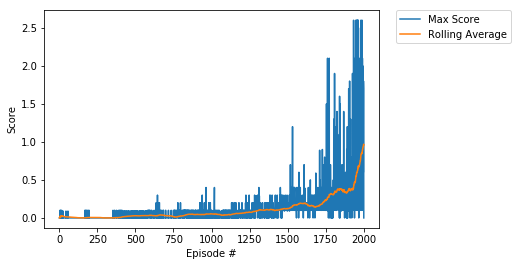

In [17]:
plot_results(scores_total, rolling_score_averages)